#### Econometrics1
#### OLS Regression; Instrumental Variables (IV) and 2SLS; Causal Inference (Causal Graphs, Relevance Condition); Simulation and Data Analysis (Generating Data, Real-World Application)
#### Mingshu Li

## Problem 1

By addinig and substrating, we get $y - X\overline{\beta} = (y - X\hat{\beta}^{OLS}) - (X\overline{\beta} - X\hat{\beta}^{OLS})$

Then the SSR for any other estimate $\overline{\beta}$ is

$ = ((y - X\hat{\beta}^{OLS}) - (X\overline{\beta} - X\hat{\beta}^{OLS}))'((y - X\hat{\beta}^{OLS}) - (X\overline{\beta} - X\hat{\beta}^{OLS}))$

$ = ((y - X\hat{\beta}^{OLS})' - (X\overline{\beta} - X\hat{\beta}^{OLS})')((y - X\hat{\beta}^{OLS}) - (X\overline{\beta} - X\hat{\beta}^{OLS}))$

$ = (y - X\hat{\beta}^{OLS})' (y - X\hat{\beta}^{OLS}) - (y - X\hat{\beta}^{OLS})'(X\overline{\beta} - X\hat{\beta}^{OLS}) - (y - X\hat{\beta}^{OLS})(X\overline{\beta} - X\hat{\beta}^{OLS})' + (X\overline{\beta} - X\hat{\beta}^{OLS})'(X\overline{\beta} - X\hat{\beta}^{OLS})$

$ = (y - X\hat{\beta}^{OLS})'(y - X\hat{\beta}^{OLS}) - 2(y - X\hat{\beta}^{OLS})'(X\overline{\beta} - X\hat{\beta}^{OLS}) + (X\overline{\beta} - X\hat{\beta}^{OLS})'(X\overline{\beta} - X\hat{\beta}^{OLS})$

The middle part is the residual u times predictor, since they are orthogonal, $u'*X\beta$ , it goes to 0

$ = (y - X\hat{\beta}^{OLS})'(y - X\hat{\beta}^{OLS}) + (X\overline{\beta} - X\hat{\beta}^{OLS})'(X\overline{\beta} - X\hat{\beta}^{OLS})$

Comparing to the SSR of $\hat{\beta}^{OLS}$, the first part is exactly same to $\hat{\beta}^{OLS}$, but adding the square of the difference between OLS estimator and other estimator. Since the last part must be either 0 or a positive number

$ (y - X\hat{\beta}^{OLS})'(y - X\hat{\beta}^{OLS}) + (X\overline{\beta} - X\hat{\beta}^{OLS})'(X\overline{\beta} - X\hat{\beta}^{OLS}) \ge (y - X\hat{\beta}^{OLS})'(y - X\hat{\beta}^{OLS})$

So, 
$ (y - X\overline{\beta})'(y - X\overline{\beta}) \ge (y - X\hat{\beta}^{OLS})'(y - X\hat{\beta}^{OLS}) $


## Problem 2

In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.gmm import IV2SLS
from matplotlib import pyplot as plt

np.random.seed(0)
n = 1000

x = np.random.normal(-1, np.sqrt(4), n)

u = np.random.normal(0, np.sqrt(4), n)

z_list = []
d_list = []
y_list = []

sigma_50 = np.linspace(0.1, 100, 50)

for sigma in sigma_50:
    z = np.random.normal(0, sigma, n)
    z_list.append(z)
    d = np.random.normal(1 + 0.3*z + 1.5*u, np.sqrt(25), n)
    d_list.append(d)
    y = np.random.normal(-3.5 + 1.2*x + 0.66*u + 2*d, np.sqrt(25), n)
    y_list.append(y)


### 2.1

In [7]:
np.random.seed(0)
for i in range(len(sigma_50)):
    # Create a DataFrame for the ith dataset
    df = pd.DataFrame({
        'x': x,
        'u': u,
        'z': z_list[i],
        'd': d_list[i],  # ith set of d values
        'y': y_list[i]   # ith set of y values
    })

    model = smf.ols(formula='y ~ x + d', data=df).fit()

    print(f"Under sigma = {sigma_50[i]}")
    print(model.summary())


Under sigma = 0.1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     3009.
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:37:00   Log-Likelihood:                -3041.6
No. Observations:                1000   AIC:                             6089.
Df Residuals:                     997   BIC:                             6104.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3784      0.185  

### 2.2
For $\hat{\beta}^{OLS}_2$ to represent the causal effect of d on y, d has to be exogenous. Looking at the distribution of d ~ N(1 + 0.3z - 1.5u, 25), E(u|d) $\ne$ 0, d is endogenous. The error term u is affecting both d and y, an alternative path through u, this OLS estimator will not estimate the casual effect correctly.
Causal graph:b

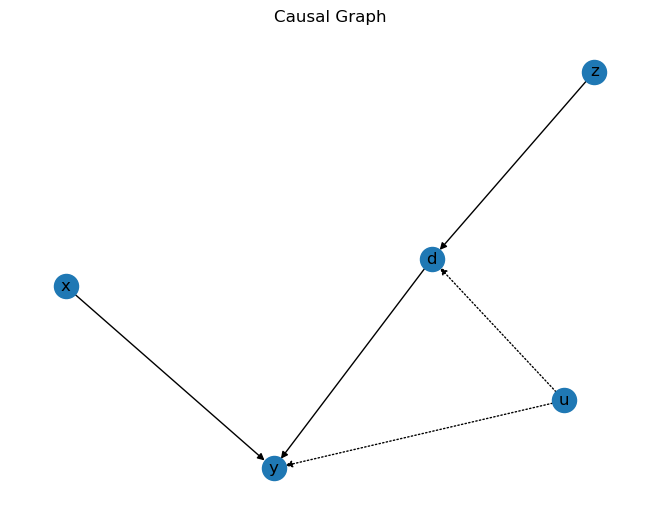

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_node('x')
G.add_node('y')
G.add_node('d')
G.add_node('z')
G.add_node('u')

edges = [('x', 'y'), ('d', 'y'), ('z', 'd')]
G.add_edges_from(edges)

u_edges = [('u', 'd'), ('u', 'y')]
G.add_edges_from(u_edges)

pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=True, arrows=True, edgelist=edges, style='solid')  
nx.draw_networkx_edges(G, pos, edgelist=u_edges,style='dotted') 

plt.title("Causal Graph")
plt.show()

### 2.3

In [11]:
np.random.seed(0)
for i in range(len(sigma_50)):
    df = pd.DataFrame({
        'x': x,
        'u': u,
        'z': z_list[i],
        'd': d_list[i],  
        'y': y_list[i]
    })

    first_stage = smf.ols(formula='d ~ x + z', data=df).fit(covtype = 'HC3')
    
    print(f"under sigma = {sigma_50[i]}")
    print("z parameter estimate:, ", first_stage.params["z"])
    print("z p-value:, ", first_stage.pvalues["z"])


under sigma = 0.1
z parameter estimate:,  0.8378251460755219
z p-value:,  0.6687959197480529
under sigma = 2.138775510204082
z parameter estimate:,  0.3740385730291249
z p-value:,  2.9118499722184512e-05
under sigma = 4.177551020408163
z parameter estimate:,  0.30229847903366536
z p-value:,  4.906834266222722e-11
under sigma = 6.216326530612245
z parameter estimate:,  0.3436727797235498
z p-value:,  1.4362419486664833e-29
under sigma = 8.255102040816327
z parameter estimate:,  0.3030690842184522
z p-value:,  2.1565846336966714e-35
under sigma = 10.29387755102041
z parameter estimate:,  0.3059847341687997
z p-value:,  2.0717012276250034e-62
under sigma = 12.332653061224491
z parameter estimate:,  0.3102309856289027
z p-value:,  1.0554596111227217e-82
under sigma = 14.371428571428572
z parameter estimate:,  0.31030675142908154
z p-value:,  2.670784023056183e-106
under sigma = 16.410204081632656
z parameter estimate:,  0.301101122528291
z p-value:,  2.026410435002022e-123
under sigma = 18

We can see a trend from the data, as sigma gets larger, the p-value of z parameter estimate gets smaller to 0. Except when sigma = 0.1, under all other conditions, the p-value is <0.01. Z is signigicanlty predictor of d, which the coefficient is significantly different from 0.  

### 2.4

In [14]:
np.random.seed(0)
for i in range(len(sigma_50)):
    df = pd.DataFrame({
        'x': x,
        'u': u,
        'z': z_list[i],
        'd': d_list[i],  
        'y': y_list[i]
    })

    first_stage = smf.ols(formula='d ~ x + z', data=df).fit(covtype = 'HC3')
        
    df['d_ols'] = first_stage.fittedvalues
    
    second_stage = sm.OLS(df['y'], sm.add_constant(df[['x', 'd_ols']])).fit()
                                 
    print(f"under sigma = {sigma_50[i]}")
    print(second_stage.summary())

under sigma = 0.1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     15.62
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           2.10e-07
Time:                        21:37:01   Log-Likelihood:                -4001.7
No. Observations:                1000   AIC:                             8009.
Df Residuals:                     997   BIC:                             8024.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1355      4.828  

### 2.5

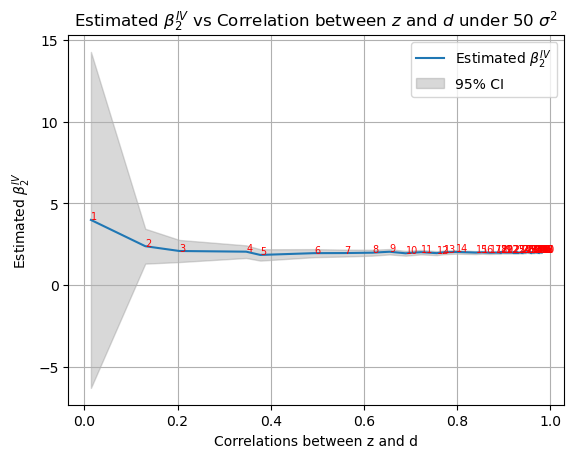

In [16]:
np.random.seed(0)
coefficients_iv = []
conf_intervals = []
correlations = []

for i in range(len(sigma_50)):
    df = pd.DataFrame({
        'x': x,
        'u': u,
        'z': z_list[i],
        'd': d_list[i],  
        'y': y_list[i]
    })

    first_stage = smf.ols(formula='d ~ x + z', data=df).fit(covtype = 'HC3')
        
    df['d_ols'] = first_stage.fittedvalues
    
    second_stage = sm.OLS(df['y'], sm.add_constant(df[['x', 'd_ols']])).fit()
    
    coeff = second_stage.params['d_ols']
    conf_int = second_stage.conf_int().loc['d_ols']
    
    coefficients_iv.append(coeff)
    conf_intervals.append(conf_int)
    
    corr = np.corrcoef(df['z'], df['d'])[0, 1]
    correlations.append(corr)

conf_intervals = np.array(conf_intervals)

plt.plot(correlations, coefficients_iv, label='Estimated $\\beta_2^{IV}$')
plt.fill_between(correlations, conf_intervals[:, 0], conf_intervals[:, 1], color='gray', alpha=0.3, label='95% CI')
for i in range(len(sigma_50)):
    plt.text(correlations[i], coefficients_iv[i], str(i+1), fontsize=7, color='red')

plt.xlabel('Correlations between z and d')
plt.ylabel('Estimated $\\beta_2^{IV}$')
plt.title('Estimated $\\beta_2^{IV}$ vs Correlation between $z$ and $d$ under 50 $\\sigma^2$')
plt.legend()
plt.grid(True)


### 2.6
As sigma increase, the confidence interval gets tighter and the estimate of $\beta_2^{IV}$ is showing consistency and stability.
Comparing the results of two estimator $\hat{\beta}^{OLS}_2$ and $\beta_2^{IV}$, there wasn't significant difference between them, which indicates that the endogenous problem is not severe or none.

### 3.1

In [20]:
ps2 = pd.read_csv('ps2_data.csv')

ps2['parental_education'] = ps2[['meduc', 'feduc']].mean(axis=1)
descrip_stat = ps2[['wage', 'educ', 'meduc', 'feduc', 'parental_education']].describe()
print(descrip_stat)

              wage        educ       meduc       feduc  parental_education
count   935.000000  935.000000  857.000000  741.000000          876.000000
mean    957.945455   13.468449   10.682614   10.217274           10.414384
std     404.360822    2.196654    2.849756    3.300700            2.765518
min     115.000000    9.000000    0.000000    0.000000            1.000000
25%     669.000000   12.000000    8.000000    8.000000            8.375000
50%     905.000000   12.000000   12.000000   10.000000           11.000000
75%    1160.000000   16.000000   12.000000   12.000000           12.000000
max    3078.000000   18.000000   18.000000   18.000000           18.000000


education and parental education are relevant variables, since we want to model how education affects wages and parental education for IV later on. 
Since the parental education variable are spereate into two, mom's and dad's, I would like to save their mean to a new column called 'parental_education' to be the IV for further analysis. 
Here is our diagram for casual relationship:

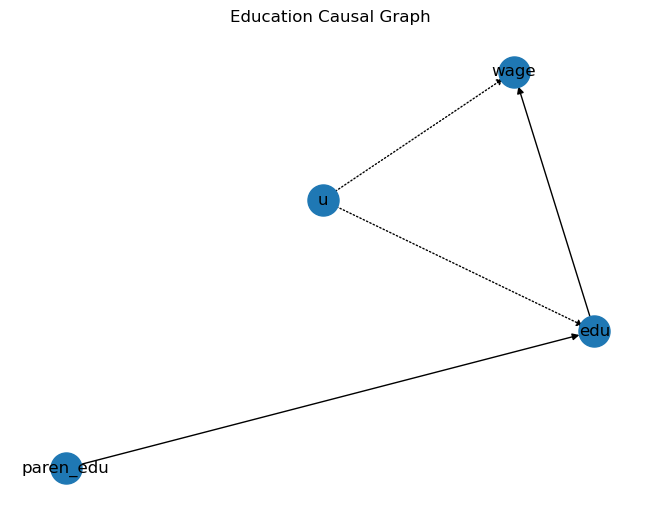

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_node('wage')
G.add_node('edu')
G.add_node('paren_edu')
G.add_node('u')

edges = [('edu', 'wage'), ('paren_edu', 'edu')]
G.add_edges_from(edges)

u_edges = [('u', 'wage'), ('u', 'edu')]
G.add_edges_from(u_edges)

pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=True, arrows=True, edgelist=edges, style='solid', node_size=500)  
nx.draw_networkx_edges(G, pos, edgelist=u_edges, style='dotted') 

plt.title("Education Causal Graph")
plt.show()

### 3.2

In [24]:
ps2_ols_model = smf.ols('wage ~ educ', data=ps2).fit()

# Display the results of the OLS regression
print(ps2_ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     111.8
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           9.35e-25
Time:                        21:37:01   Log-Likelihood:                -6885.5
No. Observations:                 935   AIC:                         1.377e+04
Df Residuals:                     933   BIC:                         1.378e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    146.9524     77.715      1.891      0.0

Taking all other variables in the dataset as error, the effect of education on wages, $\hat{\beta}^{OLS}$ is 60.2143 and the p-value appriximate to 0 indicating significant. 

### 3.3

In [27]:
first_stage = smf.ols('educ ~ parental_education', data=ps2).fit(covtype = 'HC3')

print("parental_education parameter estimate:, ", first_stage.params["parental_education"])
print("parental_education p-value:, ", first_stage.pvalues["parental_education"])

ps2['educ_hat'] = first_stage.fittedvalues
second_stage = smf.ols('wage ~ educ_hat', data=ps2).fit(covtype = 'HC3')
print(second_stage.summary())


parental_education parameter estimate:,  0.34251750305897427
parental_education p-value:,  9.380970556351762e-41
                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     54.94
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           2.93e-13
Time:                        21:37:01   Log-Likelihood:                -6476.0
No. Observations:                 876   AIC:                         1.296e+04
Df Residuals:                     874   BIC:                         1.297e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

By applying parental education as the Instrument Variable to 2SLS, the effect of education on wages, $\hat{\beta}^{IV}$ is 104.0807, the p-value appriximate to 0 indicating significant. 
Conditions to identify the causal effect, we have to satisfy that parental_education is correlated with education. Results from first stage give the parameter estimation for IV is 0.3425 and the p-value is < 0.01, which the coefficient is significantly different from 0. The parental_education is predictor of d

### 3.4

In [30]:
summary_data = {
    " ": ["Parameters", "" , "R-squared", "N"],
    "OLS": [f'{ps2_ols_model.params["educ"]:.2f}', f"({ps2_ols_model.bse["educ"]:.2f})", f'{ps2_ols_model.rsquared:.2f}', int(ps2_ols_model.nobs)],
    "Second_stage": [f'{second_stage.params["educ_hat"]:.2f}', f"({second_stage.bse['educ_hat']:.2f})", f'{second_stage.rsquared:.2f}', int(second_stage.nobs)],
}
summary_df = pd.DataFrame(summary_data)

markdown_table = summary_df.to_markdown(index=False)

print(markdown_table)

|            | OLS    | Second_stage   |
|:-----------|:-------|:---------------|
| Parameters | 60.21  | 104.08         |
|            | (5.69) | (14.04)        |
| R-squared  | 0.11   | 0.06           |
| N          | 935    | 876            |


The difference between two estimator $\hat{\beta}^{OLS}_2$ and $\beta_2^{IV}$ is quite large, which indiates that there is endogenous, the OLS estimator is biased, which the error term is correlated with education.
By applying the IV, It helps eliminates parts of bias from endogeneity, which provides a more accurate estimator